# Music Genre Classification

Classify the musical genre of a given audio track - from data to deployed model. Adapted from the work of Huang, Serafini, and Pugh [1].

## Authors
- Sebastian Lehrig <sebastian.lehrig1@ibm.com>
- Marvin Giessing <MARVING@de.ibm.com>

## License
Apache-2.0 License

## References
[1] original paper: http://cs229.stanford.edu/proj2018/report/21.pdf

[2] code: https://github.com/derekahuang/Music-Classification

[3] Preprocessed Data: https://drive.google.com/file/d/12mCgkvbmissLh2Vop0bp_t98G8QCaV1E/view?usp=sharing

## 0.) Imports & Constants

In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [64]:
import IPython.display
import json
import kfp
import kfp.dsl as dsl
from kfp.components import (
    InputPath,
    OutputPath
)
import librosa as lb
from librosa import display
import math
import numpy as np
import pylab
import requests
from typing import NamedTuple

In [3]:
GENRE_LABELS = [
    "Blues",
    "Classical",
    "Country",
    "Disco",
    "Hip hop",
    "Jazz",
    "Metal",
    "Pop",
    "Reggae",
    "Rock"
]

CONVERT_MODEL_TO_ONNX_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-building/convert-to-onnx/component.yaml"
UPLOAD_MODEL_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-building/upload-model/component.yaml"
DEPLOY_MODEL_WITH_KSERVE_COMPONENT_URL = "https://raw.githubusercontent.com/lehrig/kubeflow-ppc64le-components/main/model-deployment/deploy-model-with-kserve/component.yaml"

DATASET_URL = "https://ibm.box.com/shared/static/8qwoumhfopcex2lqjslhlm1i9r8svlhw.npz"
DATASET_FILE_NAME = "melspects.npz"
MODEL_NAME = "music-genre-classification"

MINIO_URL = "minio-service.kubeflow:9000"
MINIO_USER = "minio"
MINIO_PASS = "minio123"

with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
    NAMESPACE = f.read()
NAMESPACE

'user-example-com'

## 1.) Let's start with creating a client object for interaction

In [4]:
client = kfp.Client()

## 2.) The main part consists of defining the end-to-end workflow functions and create components from them
### 2.1) Download data

In [5]:
def download_data(
    url: str,
    file_name: str,
    data_dir: OutputPath(str)
):
    import os
    import requests

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    file = f'{data_dir}/{file_name}'
    print(f'Downloading data from {url}...')
    r = requests.get(url, allow_redirects=True)
    open(file, 'wb').write(r.content)

    print(f'Data saved to {file}.')


download_data_comp = kfp.components.create_component_from_func(
    func=download_data,
    output_component_file='preprocess_data_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-cpu:latest'
)

### 2.2) Preprocess data

In [6]:
def preprocess_data(
    data_dir: InputPath(str),
    file_name: str,
    prep_data_dir: OutputPath(str)
):
    """Split data into train/validate/test data. Saves result into `prep_data_dir`."""

    import os
    import numpy as np
    from tensorflow.keras import utils as np_utils

    def randomPermutation(dataArray):
        return np.random.permutation(len(dataArray))

    def extendDimension(dataArray):
        return dataArray[:, :, :, np.newaxis]

    def categorize(dataArray):
        return np_utils.to_categorical(dataArray)

    def prepareVariables(independentVariable, dependentVariable):
        permutation = randomPermutation(independentVariable)
        return (extendDimension(independentVariable[permutation]),
                categorize(dependentVariable[permutation]))

    file = f'{data_dir}/{file_name}'
    print(f'Loading input data from {file}...')
    data = np.load(file)

    trainingData = prepareVariables(data['x_tr'], data['y_tr'])
    validationData = prepareVariables(data['x_cv'], data['y_cv'])
    testData = prepareVariables(data['x_te'], data['y_te'])

    if not os.path.exists(prep_data_dir):
        os.makedirs(prep_data_dir)

    np.savez(
        f'{prep_data_dir}/prepared_data.npz',
        x_train=trainingData[0],
        y_train=trainingData[1],
        x_validate=validationData[0],
        y_validate=validationData[1],
        x_test=testData[0],
        y_test=testData[1]
    )

    print(f'Data saved to {prep_data_dir}:')
    print(os.listdir(prep_data_dir))


preprocess_data_comp = kfp.components.create_component_from_func(
    func=preprocess_data,
    output_component_file='preprocess_data_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-cpu:latest'
)

### 2.3) Train the model

In [7]:
def train_model(
    prep_data_dir: InputPath(str),
    model_dir: OutputPath(str)
):
    """Trains CNN model. Once trained, the model is persisted to `model_dir`."""

    import os
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv2D, MaxPooling2D
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras import regularizers
    import time

    model = Sequential()

    # Feature Learning Layers
    model.add(Conv2D(64,
                     kernel_size=(4, 4),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.04),
                     input_shape=(64, 173, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))

    model.add(Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Classification Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=[tf.keras.metrics.categorical_accuracy])
    print(model.summary())

    batch_size = 200
    epochs = 10
    data = np.load(f'{prep_data_dir}/prepared_data.npz')

    start = time.time()
    hist = model.fit(
        x=data['x_train'],
        y=data['y_train'],
        validation_data=(data['x_validate'],
                         data['y_validate']),
        batch_size=batch_size,
        epochs=epochs)
    print("\n\nTraining took ", time.time()-start, "seconds")

    print("Model train history:")
    print(hist.history)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(model_dir)
    print(f"Model saved to: {model_dir}")


train_model_comp = kfp.components.create_component_from_func(
    func=train_model,
    output_component_file='train_model_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-gpu:2.7.0-dev'
)

### 2.4) Evaluate model with validation data

In [8]:
def evaluate_model(
    prep_data_dir: InputPath(str),
    model_dir: InputPath(str),
    metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import numpy as np
    import tensorflow as tf
    from collections import namedtuple

    data = np.load(f'{prep_data_dir}/prepared_data.npz')

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(data['x_test'], data['y_test'])

    print((loss, accuracy))

    metrics = {
        "metrics": [
            {
                "name": "loss",
                "numberValue": str(loss),
                "format": "PERCENTAGE"
            },
            {
                "name": "accuracy",
                "numberValue": str(accuracy),
                "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))


evaluate_model_comp = kfp.components.create_component_from_func(
    func=evaluate_model,
    output_component_file='evaluate_model_component.yaml',
    base_image='quay.io/ibm/kubeflow-component-tensorflow-cpu:latest'
)

### 2.5) Create confusion matrix

In [9]:
def plot_confusion_matrix(
        prep_data_dir: InputPath(str),
        model_dir: InputPath(str),
        labels: list,
        mlpipeline_ui_metadata_path: OutputPath()):
    import json
    import logging
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import sys
    import tensorflow as tf

    logging.basicConfig(
        stream=sys.stdout,
        level=logging.INFO,
        format='%(levelname)s %(asctime)s: %(message)s'
    )

    data = np.load(f'{prep_data_dir}/prepared_data.npz')
    model = tf.keras.models.load_model(model_dir)

    y_true = np.argmax(data['y_test'], axis=1)
    y_pred = np.argmax(model.predict(data['x_test']), axis=1)
    confusion_matrix = confusion_matrix(y_true, y_pred)

    data = []
    for target_index, target_row in enumerate(confusion_matrix):
        for predicted_index, count in enumerate(target_row):
            data.append((labels[target_index], labels[predicted_index], count))

    df = pd.DataFrame(
        data,
        columns=['target', 'predicted', 'count']
    )

    metadata = {
      'outputs': [{
        'type': 'confusion_matrix',
        'format': 'csv',
        'schema': [
          {'name': 'target', 'type': 'CATEGORY'},
          {'name': 'predicted', 'type': 'CATEGORY'},
          {'name': 'count', 'type': 'NUMBER'},
        ],
        "storage": "inline",
        'source': df.to_csv(
            columns=['target', 'predicted', 'count'],
            header=False,
            index=False),
        'labels': labels,
      }]
    }

    logging.info("Dumping mlpipeline_ui_metadata...")
    with open(mlpipeline_ui_metadata_path, 'w') as metadata_file:
        json.dump(metadata, metadata_file)

    logging.info("Finished.")


plot_confusion_matrix_comp = kfp.components.create_component_from_func(
    func=plot_confusion_matrix,
    output_component_file='plot_confusion_matrix_component.yaml',
    base_image='quay.io/ibm/kubeflow-notebook-image-ppc64le:elyra3.7.0-py3.8-tensorflow-cpu2.7.0'
)

### 2.6) Convert model to ONNX (by reusing a Kubeflow component)

In [10]:
convert_model_to_onnx_comp = kfp.components.load_component_from_url(
    CONVERT_MODEL_TO_ONNX_COMPONENT_URL
)

### 2.7) Upload model to MinIO artifact store (by reusing a Kubeflow component)

In [11]:
upload_model_comp = kfp.components.load_component_from_url(
    UPLOAD_MODEL_COMPONENT_URL
)

### 2.8) Deploy the model using KServe (by reusing a Kubeflow component)

In [12]:
deploy_model_with_kserve_comp = kfp.components.load_component_from_url(
    DEPLOY_MODEL_WITH_KSERVE_COMPONENT_URL
)

## 3.) Create the actual pipeline by combining the components

In [13]:
@dsl.pipeline(
  name='End-to-end music genre classification pipeline',
  description='An example pipeline that performs a music genre classification on audio data'
)
def music_genre_classification_pipeline(
            labels: list,
            dataset_url: str,
            dataset_file_name: str = "data.zip",
            data_dir: str = "/train/data",
            prep_data_dir: str = "/train/prep_data",
            model_dir: str = "/train/model",
            model_name: str = "monkey-classification",
            minio_url: str = MINIO_URL,
            minio_user: str = MINIO_USER,
            minio_pass: str = MINIO_PASS):
    download_data_task = download_data_comp(
        url=dataset_url,
        file_name=dataset_file_name
    )

    preprocess_data_task = preprocess_data_comp(
        download_data_task.outputs['data_dir'],
        file_name=dataset_file_name
    )

    train_model_task = train_model_comp(
        preprocess_data_task.output
    ).set_gpu_limit(1)

    evaluate_model_task = evaluate_model_comp(
        preprocess_data_task.output,
        train_model_task.output
    )

    plot_confusion_matrix_task = plot_confusion_matrix_comp(
        preprocess_data_task.output,
        train_model_task.output,
        labels
    )

    convert_model_to_onnx_task = convert_model_to_onnx_comp(
        train_model_task.output
    )

    upload_model_task = upload_model_comp(
        convert_model_to_onnx_task.output,
        minio_url,
        minio_user,
        minio_pass,
        model_name=model_name
    )

    deploy_model_with_kserve_task = deploy_model_with_kserve_comp(
        model_name=model_name
    )

    deploy_model_with_kserve_task.after(upload_model_task)

## 4.) Run the pipline within an experiment
Create a pipeline run, using the client you initialized in a prior step.

In [15]:
arguments = {
    'labels': GENRE_LABELS,
    'dataset_url': DATASET_URL,
    'dataset_file_name': DATASET_FILE_NAME,
    'data_dir': '/train/data',
    'prep_data_dir': '/train/prep_data',
    'model_dir': '/train/model',
    'model_name': MODEL_NAME,
    'minio_url': MINIO_URL,
    'minio_user': MINIO_USER,
    'minio_pass': MINIO_PASS
}

client.create_run_from_pipeline_func(
    music_genre_classification_pipeline,
    arguments=arguments,
    namespace=NAMESPACE
)

RunPipelineResult(run_id=a4d7ff14-8bb4-4256-869b-d8443225ed6f)

## 5.) Test model deployment
See API documentation: https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

### 5.1) Check model endpoint availability

In [18]:
HOST = MODEL_NAME + "-predictor-default." + NAMESPACE
HEADERS = {'Host': HOST}
MODEL_ENDPOINT = "http://" + MODEL_NAME + "-predictor-default/v2/models/" + MODEL_NAME

res = requests.get(MODEL_ENDPOINT, headers=HEADERS)
response = json.loads(res.text)
response

{'name': 'music-genre-classification',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'conv2d_input',
   'datatype': 'FP32',
   'shape': [-1, 64, 173, 1]}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': [-1, 10]}]}

Note you can also do this:
```curl -H "Host: $HOST" $MODEL_ENDPOINT```

### 5.2) Get test audio
See: https://commons.wikimedia.org/wiki/Category:Audio_files_of_blues

In [94]:
AUDIO = "audio.ogg"
AUDIO_URL = "https://upload.wikimedia.org/wikipedia/commons/7/7b/12barBlues002.ogg"

!wget $AUDIO_URL -O $AUDIO

--2022-05-05 12:15:36--  https://upload.wikimedia.org/wikipedia/commons/7/7b/12barBlues002.ogg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144807 (1.1M) [application/ogg]
Saving to: ‘audio.ogg’

audio.ogg           100%[===================>]   1.09M  5.86MB/s    in 0.2s    

2022-05-05 12:15:37 (5.86 MB/s) - ‘audio.ogg’ saved [1144807/1144807]



In [95]:
IPython.display.Audio(AUDIO)

### 5.3) Convert test audio to 2-seconds Mel Spectrograms

In [96]:
SR = 22050
N_FFT = 512
HOP_LENGTH = N_FFT // 2
N_MELS = 64


def convert_to_melspecs(filename):
    audios = get_batches(filename)
    return batch_log_melspectrogram(audios)


def get_batches(audio):
    y, sr = lb.load(audio, mono=True)

    duration = lb.core.get_duration(y)

    audios = []
    # prune first 2 seconds and ending (assumption: does not include important data)
    for i in range(2, math.floor(duration), 2):
        y_sample, sr_sample = lb.load(audio, mono=True, offset=i, duration=2.0)
        audios.append(y_sample)

    return audios


def log_melspectrogram(data):
    melspec = lb.feature.melspectrogram(
        y=data,
        hop_length=HOP_LENGTH,
        n_fft=N_FFT,
        n_mels=N_MELS)
    return lb.power_to_db(melspec**2)


def batch_log_melspectrogram(data_list):
    melspecs = np.asarray([
        log_melspectrogram(data_list[i]) for i in range(len(data_list)-1)
    ])
    melspecs = melspecs.reshape(
        melspecs.shape[0],
        melspecs.shape[1],
        melspecs.shape[2],
        1
    )
    return melspecs


melspecs = convert_to_melspecs(AUDIO)

/tmp/ipykernel_10365/3707286731.py:15: FutureWarning: Pass y=[-0.01303587 -0.03345034 -0.04761556 ...  0.00386118  0.00374244
  0.00445707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = lb.core.get_duration(y)


### 5.4) Visualize a Mel Spectrogram

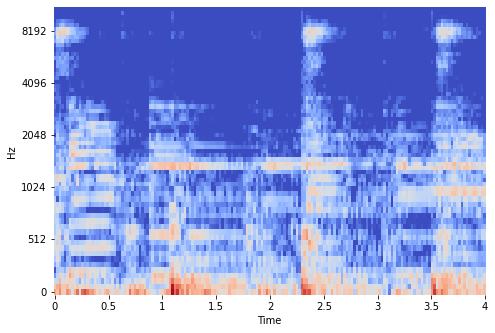

In [97]:
middle = (int)(melspecs.shape[0]/2)
example_melspec = melspecs[middle]
example_melspec = example_melspec.reshape(example_melspec.shape[0], example_melspec.shape[1])

pylab.axis('off') # no axis
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
display.specshow(example_melspec, y_axis='mel', x_axis='time')

### 5.5) Score example Mel Spectromgram against model 

In [98]:
def score(melspec):
    PREDICT_ENDPOINT = MODEL_ENDPOINT + "/infer"
    
    payload = {
      "inputs": [{
          "name": "conv2d_input",
          "shape": [1, 64, 173, 1],
          "datatype": "FP32",
          "data": melspec.tolist()
        }
      ]
    }

    res = requests.post(PREDICT_ENDPOINT, headers=HEADERS, data=json.dumps(payload))
    response = json.loads(res.text)
    return response['outputs'][0]['data']

test_score = score(example_melspec)
test_score

[0.03771468997001648,
 0.03203390911221504,
 0.1219385415315628,
 0.1257960945367813,
 0.070229671895504,
 0.04958285391330719,
 0.16653946042060852,
 0.09817448258399963,
 0.06797445565462112,
 0.2300158441066742]

In [99]:
GENRE_LABELS[np.argmax(test_score)]

'Rock'

### 5.6) Score each Mel Spectrogram against deployed model & aggregate results

In [100]:
probabilities = [0.0 for genre in GENRE_LABELS]
counts = [0 for genre in GENRE_LABELS]

for melspec in melspecs:
    predictions = score(melspec)
    for i in range(len(GENRE_LABELS)):
        probabilities[i] += predictions[i]
    counts[np.argmax(predictions)] += 1

### 5.7) Aggregate results

In [101]:
for i in range(len(GENRE_LABELS)):
    probabilities[i] = probabilities[i]/len(melspecs)
    print(GENRE_LABELS[i] + ": " + str(probabilities[i]) + " (" + str(counts[i]) + "x)")

Blues: 0.05041903565870598 (0x)
Classical: 0.042152555484790355 (0x)
Country: 0.1330189153086394 (1x)
Disco: 0.11281806137412786 (0x)
Hip hop: 0.07792456931201741 (0x)
Jazz: 0.06292947160545737 (2x)
Metal: 0.12853514961898327 (2x)
Pop: 0.11753566982224584 (1x)
Reggae: 0.08274660905590281 (1x)
Rock: 0.1919199584517628 (25x)
